In [13]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import yellowbrick as yb

from utilities import timeseries_train_test_split

### Predict Energy consumption

In [14]:
dataset = pd.read_csv('data1/dataset.csv')

In [15]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Cooling:Electricity [kW](Hourly)', 'Date/Time',
       'Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Labor Day',
       'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Tha

In [16]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER']]

In [17]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Hourly)_lag,Electricity:Facility [kW](Hourly)_future,Electricity:Facility_delta_current_lag,Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),...,USA_IL_CHICAGO-OHARE,USA_MN_MINNEAPOLIS,USA_TX_HOUSTON,USA_WA_SEATTLE,USA_NV_LAS_VEGAS,USA_CA_SAN_FRANCISCO,USA_AZ_PHOENIX,USA_GA_ATLANTA,USA_MD_BALTIMORE,USA_CO_BOULDER
count,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,...,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06,1.681344e+06
mean,5.590845e+01,2.026965e+02,2.025560e+02,2.026772e+02,1.404829e-01,1.707921e+01,9.163156e+01,9.863792e-01,6.356659e+01,5.322095e+01,...,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02
std,1.333755e+02,3.242916e+02,3.241906e+02,3.242977e+02,4.486545e+02,2.739971e+01,1.960302e+02,6.945913e+00,1.751277e+02,8.321503e+01,...,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01
min,0.000000e+00,1.925019e+00,1.925019e+00,1.925019e+00,-1.556855e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.559065e+01,2.557770e+01,2.558757e+01,-9.383972e+01,5.142197e-01,2.188666e+00,0.000000e+00,0.000000e+00,8.092797e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.550283e-01,6.193922e+01,6.191023e+01,6.191023e+01,1.338881e+01,4.375339e+00,1.609931e+01,0.000000e+00,0.000000e+00,2.064387e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.513188e+01,2.192769e+02,2.190235e+02,2.192726e+02,1.056451e+02,2.552694e+01,8.383284e+01,0.000000e+00,4.629723e+01,5.323874e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.550041e+02,1.849288e+03,1.849288e+03,1.849288e+03,1.624697e+03,2.803934e+02,4.779020e+03,3.049323e+02,4.765562e+03,4.485665e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [18]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)_future"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)_future      1.000000
RefBldgLargeHotelNew                          0.681050
Water Heater:WaterSystems:Gas [kW](Hourly)    0.578111
RefBldgMediumOfficeNew                        0.416276
InteriorEquipment:Gas [kW](Hourly)            0.253330
Electricity:Facility [kW](Hourly)_lag         0.237307
RefBldgSmallHotelNew                          0.138245
Heating:Electricity [kW](Hourly)              0.114270
Gas:Facility [kW](Hourly)                     0.109453
InteriorEquipment:Electricity [kW](Hourly)    0.086249
temperatureHigh                               0.066452
RefBldgLargeOfficeNew                         0.061984
InteriorLights:Electricity [kW](Hourly)       0.055469
dewPoint                                      0.052212
Electricity:Facility [kW](Hourly)             0.042474
is_weekend                                    0.034327
USA_TX_HOUSTON                                0.031990
USA_AZ_PHOENIX                                0.029577
Monday    

In [19]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER']]

In [20]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [21]:
processed_data.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'is_weekend',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', '

In [22]:
"""
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                                    'Fans:Electricity [kW](Hourly)',
                                   'InteriorEquipment:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER',
        'time', 'sunriseTime', 'sunsetTime']]
"""
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                            'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility_delta_current_lag',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data[['Electricity:Facility [kW](Hourly)_future']]

In [23]:
# X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)

In [24]:
model = LinearRegression(normalize=True)
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))

Linear Regression model
Mean Squared Error: 400997425655788693132148736.000
Coefficient of Determination: -451875378003212739798892544.000
Coefficients: [[ 2.98235850e-02 -1.50061207e+07 -6.94789925e+10  6.94573502e+10
   9.61235744e+10 -1.45954502e-02  1.34060363e+07  1.40978618e+06
   4.34648699e+06  2.98573108e-02 -6.31853375e-03  1.17730295e-02
  -1.37659445e-03 -2.78660532e-03  1.99439117e+13 -2.89657683e-02
  -1.61415707e-01  1.51025498e-02 -1.08441496e-02  1.30129795e-02
  -1.86915943e-02 -1.10819283e-02 -1.01206501e+14  1.36463508e+14
   8.87586379e+09  4.98657243e-03 -8.94786275e+10 -8.94786275e+10
  -9.83544912e+10 -9.83544912e+10 -8.94786275e+10 -8.94786275e+10
  -8.94786275e+10  1.64170126e+11  1.64170126e+11  1.64170126e+11
   1.64170126e+11  1.64170126e+11  1.64170126e+11  1.64170126e+11
   1.64170126e+11  1.64170126e+11  1.64170126e+11  1.64170126e+11
   1.64170126e+11  1.64170126e+11  1.64170126e+11  1.64170126e+11
   1.64170126e+11 -1.11333555e+11 -1.11333555e+11 -1.11

In [25]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Ridge model
Mean Squared Error: 0.170
Coefficient of Determination: 0.808


In [26]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Ridge model
Mean squared error = 0.171
R2 score = 0.807


In [27]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.144
R2 score = 0.837


In [28]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Lasso
Mean squared error = 0.586
R2 score = 0.340


## Feature Analysis and Selection

In [29]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.489
R2 score = 0.449


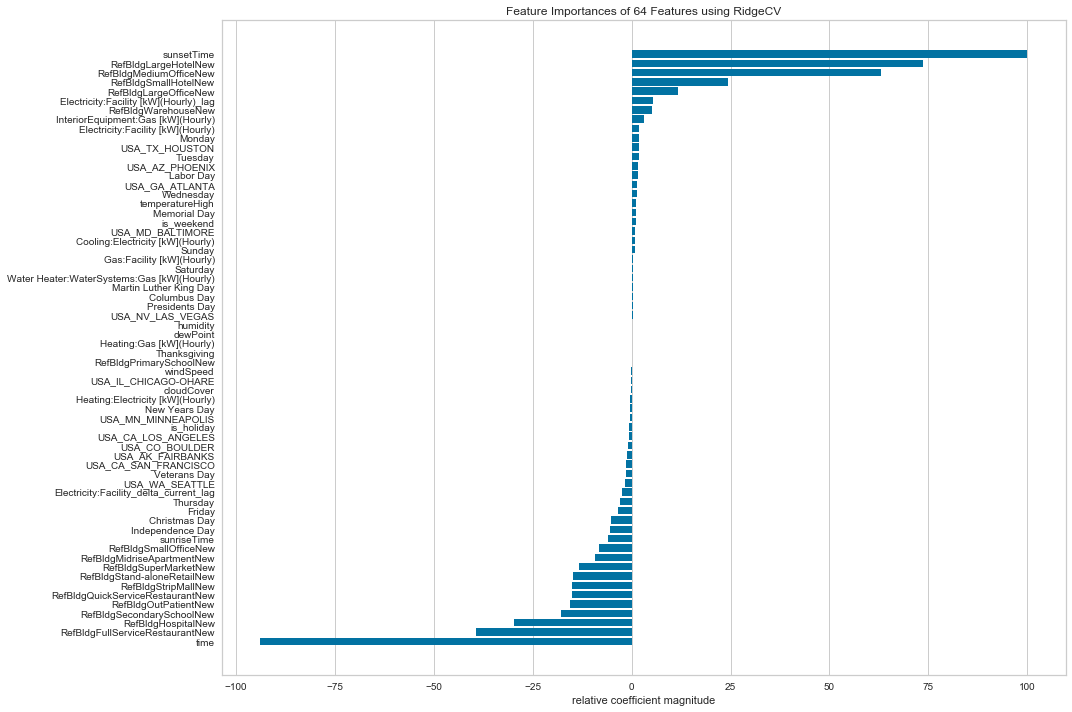

In [30]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

In [31]:
tscv = TimeSeriesSplit(n_splits=5)
#kf = KFold(n_splits=2, random_state=None, shuffle=False)
rmse = []
r2 = []
indices = []
for train_index, test_index in tscv.split(dataset_features):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dataset_features.iloc[train_index], dataset_features.iloc[test_index]
    indices.append(train_index)
    y_train, y_test = dataset_labels.iloc[train_index], dataset_labels.iloc[test_index]
    ridge = Ridge(alpha=1000)
    ridge.fit(X_train, y_train)
    expected = y_test
    predicted = ridge.predict(X_test)
    rmse.append(mse(expected, predicted))
    r2.append(r2_score(expected, predicted))
    
print('Linear Regression model')
print('Mean Squared Error: {}'.format(rmse))
print('Coefficient of Determination: {}'.format(r2))
print('Train indices: {}'.format(indices))

TRAIN: [     0      1      2 ... 280221 280222 280223] TEST: [280224 280225 280226 ... 560445 560446 560447]
TRAIN: [     0      1      2 ... 560445 560446 560447] TEST: [560448 560449 560450 ... 840669 840670 840671]
TRAIN: [     0      1      2 ... 840669 840670 840671] TEST: [ 840672  840673  840674 ... 1120893 1120894 1120895]
TRAIN: [      0       1       2 ... 1120893 1120894 1120895] TEST: [1120896 1120897 1120898 ... 1401117 1401118 1401119]
TRAIN: [      0       1       2 ... 1401117 1401118 1401119] TEST: [1401120 1401121 1401122 ... 1681341 1681342 1681343]
Linear Regression model
Mean Squared Error: [0.19546112760793602, 0.26851627607951156, 0.24283685152851608, 0.21867703746996386, 0.16425119057695495]
Coefficient of Determination: [0.797463764008284, 0.7628912403900645, 0.788711431183285, 0.7941214675080713, 0.810282579459108]
Train indices: [array([     0,      1,      2, ..., 280221, 280222, 280223]), array([     0,      1,      2, ..., 560445, 560446, 560447]), array([